# **House Prices Prediction using advanced regression techniques**

####**Introduction**

This project is part of a kaggle competition for an advanced regression task that predicts house prices based on various features. The evaluation metric is RMSE between the log-transformed predicted values and the log-transformed actual values.The objective is to minimize RMSE using different tree based models, including Linear Regression, Random Forest, XGBoost and Gradient Boosting. Log transformation is applied to ensure that errors in predicting expensive and cheap houses are treated equally.

**Import Required Libraries**

In [1]:
# data libraries
import pandas as pd
import numpy as np

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# feature engineering libraries
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# model building
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

# hyperparameter tuning libraries
from sklearn.model_selection import GridSearchCV, cross_val_score

# metrics evaluation libraries
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# feature selection libraries
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV

# warnings
import warnings
warnings.filterwarnings("ignore")

**Exploratory Data Analysis**

- Understand the data

In [2]:
df_train = pd.read_csv('train.csv', index_col='Id')
df_test = pd.read_csv('test.csv', index_col='Id')
df_train.shape, df_test.shape

((1460, 80), (1459, 79))

In [3]:
df_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
df_test['SalePrice'] = -1  # Add 'Response' column with placeholder value
combined_df = pd.concat([df_train, df_test], axis=0)
combined_df.shape

(2919, 80)

In [5]:
combined_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
combined_df.duplicated().sum(); combined_df.drop_duplicates(inplace=True)

In [7]:
combined_df.isna().sum()

,0
MSSubClass,0
MSZoning,4
LotFrontage,486
LotArea,0
Street,0
...,...
MoSold,0
YrSold,0
SaleType,1
SaleCondition,0


In [8]:
# Drop columns with more than 50% missing values
combined_df = combined_df.loc[:, combined_df.isna().mean() < 0.5]
combined_df.shape


(2919, 75)

In [9]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2919 entries, 1 to 2919
Data columns (total 75 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   LotShape       2919 non-null   object 
 6   LandContour    2919 non-null   object 
 7   Utilities      2917 non-null   object 
 8   LotConfig      2919 non-null   object 
 9   LandSlope      2919 non-null   object 
 10  Neighborhood   2919 non-null   object 
 11  Condition1     2919 non-null   object 
 12  Condition2     2919 non-null   object 
 13  BldgType       2919 non-null   object 
 14  HouseStyle     2919 non-null   object 
 15  OverallQual    2919 non-null   int64  
 16  OverallCond    2919 non-null   int64  
 17  YearBuilt      2919 non-null   int64  
 18  YearRemodAdd 

In [10]:
combined_df.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,2919.000000,2433.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,2918.000000,2918.000000,...,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,57.137718,69.305795,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,49.582248,...,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737,90491.088386
std,42.517628,23.344905,7886.996359,1.409947,1.113131,30.291442,20.894344,179.334253,455.610826,169.205611,...,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964,106496.804191
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,-1.000000
25%,20.000000,59.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,-1.000000
50%,50.000000,68.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.500000,0.000000,...,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,34900.000000
75%,70.000000,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,0.000000,...,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,163000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,...,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000


In [11]:
combined_df.describe(include='object')

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
count,2915,2919,2919,2919,2917,2919,2919,2919,2919,2919,...,2918,2917,1499,2762,2760,2760,2760,2919,2918,2919
unique,5,2,4,4,2,5,3,25,9,8,...,4,7,5,6,3,5,5,3,9,6
top,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,...,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,WD,Normal
freq,2265,2907,1859,2622,2916,2133,2778,443,2511,2889,...,1492,2717,744,1723,1230,2604,2654,2641,2525,2402


In [12]:
df_train = combined_df[combined_df['SalePrice'] != -1]
df_test = combined_df[combined_df['SalePrice'] == -1]
df_test = df_test.drop(columns=['SalePrice'])

- Visualize the data

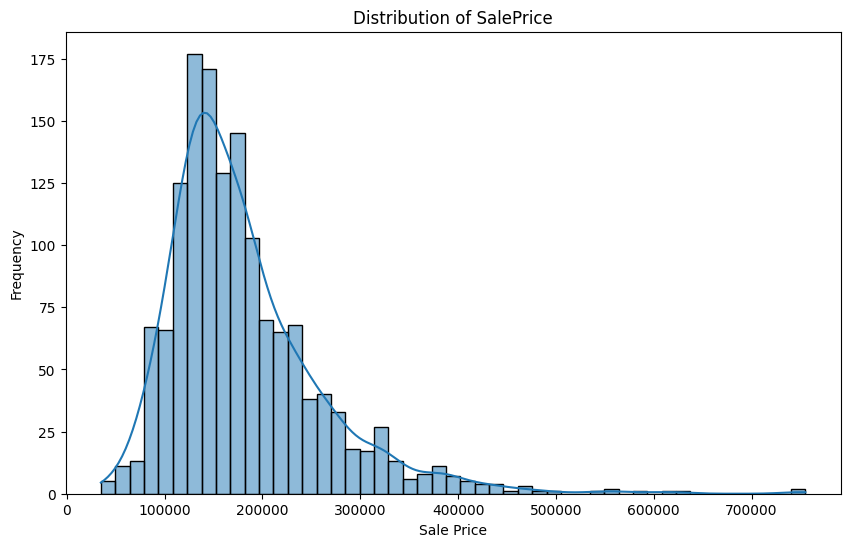

In [13]:
# Create a histogram to visualize target column
plt.figure(figsize=(10, 6))
sns.histplot(df_train['SalePrice'], kde=True)
plt.title('Distribution of SalePrice')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.show()

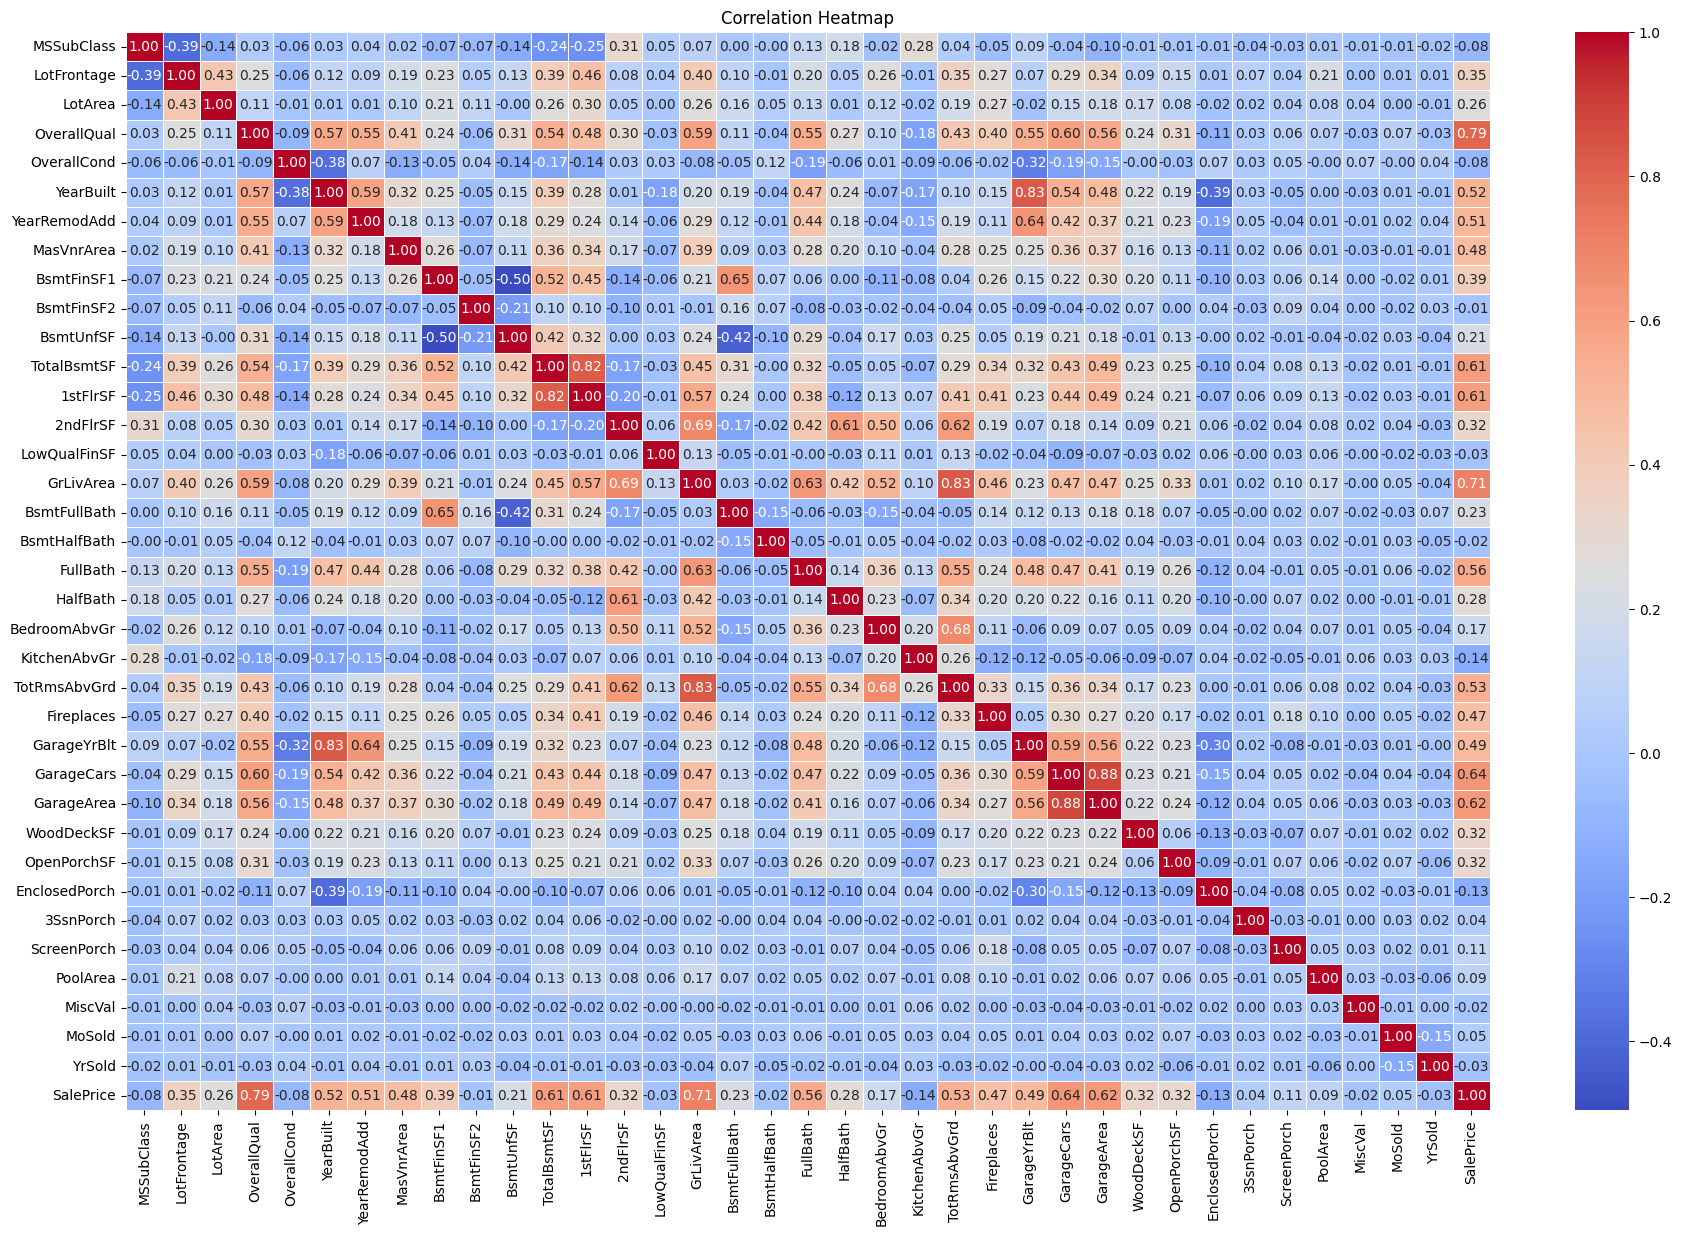

In [14]:
# Create the correlation matrix for numerical columns
numerical_columns = df_train.select_dtypes(include=['number']).columns
corr_matrix = df_train[numerical_columns].corr()

# Generate a heatmap
plt.figure(figsize=(22, 14))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [15]:
# create a correlation matrix
target_corr = corr_matrix['SalePrice'].drop('SalePrice').sort_values(ascending=False)
target_corr

,SalePrice
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897
YearRemodAdd,0.507101


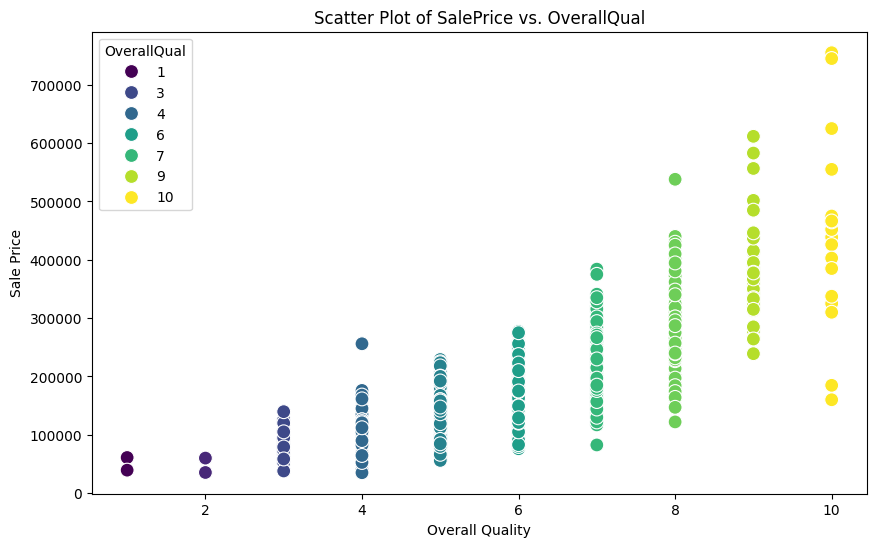

In [16]:
# Scatter plot of SalePrice vs. OverallQual
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_train['OverallQual'], y=df_train['SalePrice'], hue=df_train['OverallQual'], palette='viridis', s=100)
plt.title('Scatter Plot of SalePrice vs. OverallQual')
plt.xlabel('Overall Quality')
plt.ylabel('Sale Price')
plt.show()

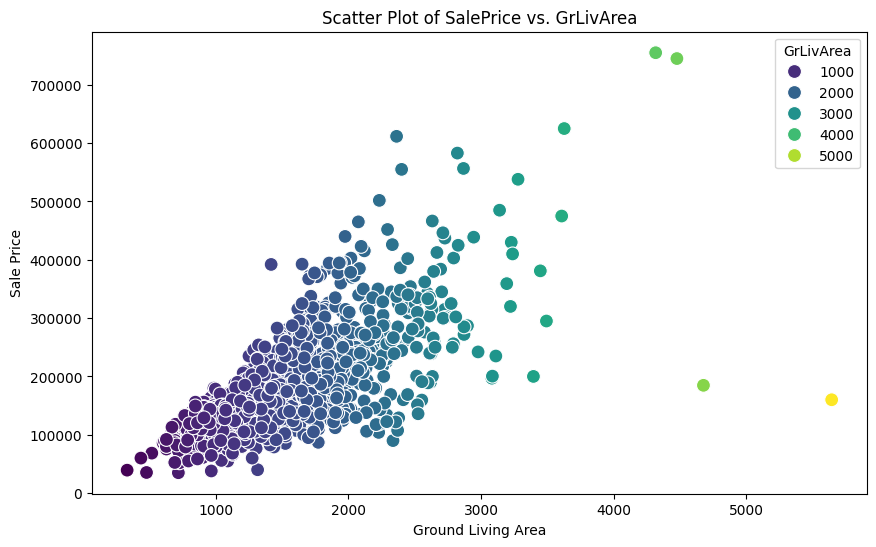

In [17]:
# Scatter plot of SalePrice vs. GrLivArea
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_train['GrLivArea'], y=df_train['SalePrice'], hue=df_train['GrLivArea'], palette='viridis', s=100)
plt.title('Scatter Plot of SalePrice vs. GrLivArea')
plt.xlabel('Ground Living Area')
plt.ylabel('Sale Price')
plt.show()

<Axes: xlabel='SalePrice', ylabel='YearRemodAdd'>

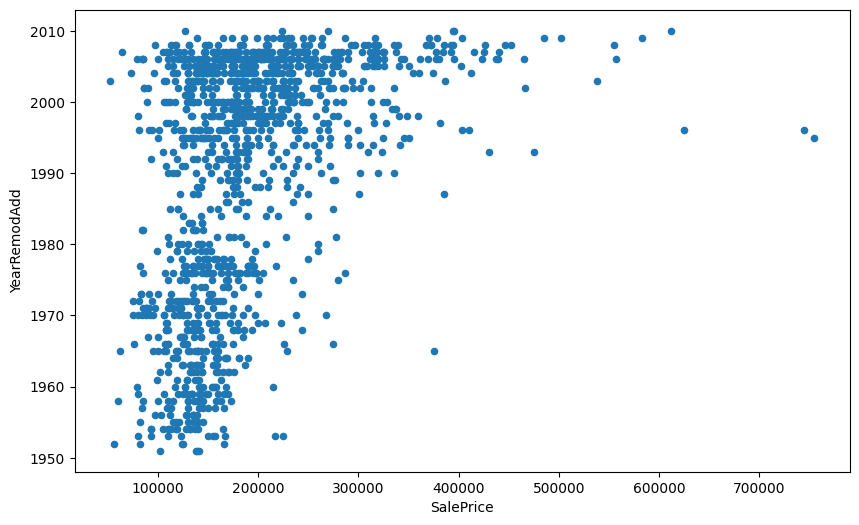

In [18]:
# Scatter plot of SalePrice vs. Year remodeled after 1950
remodel = df_train[df_train['YearRemodAdd']>1950]
remodel[['SalePrice','YearRemodAdd']].plot(kind='scatter', x='SalePrice', y='YearRemodAdd', figsize=(10,6))

<Axes: xlabel='Neighborhood'>

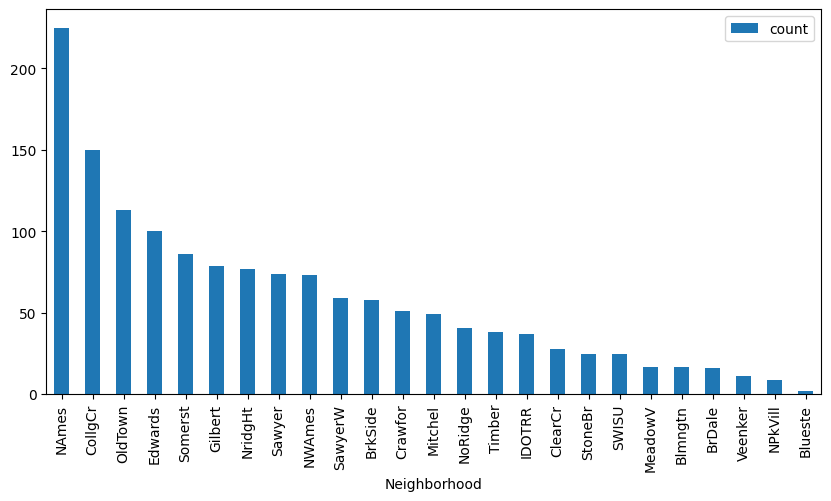

In [19]:
#visualize 'Neighborhood' in a dataframe and plot it
pd.DataFrame(df_train['Neighborhood'].value_counts()).plot(kind='bar', figsize=(10,5))

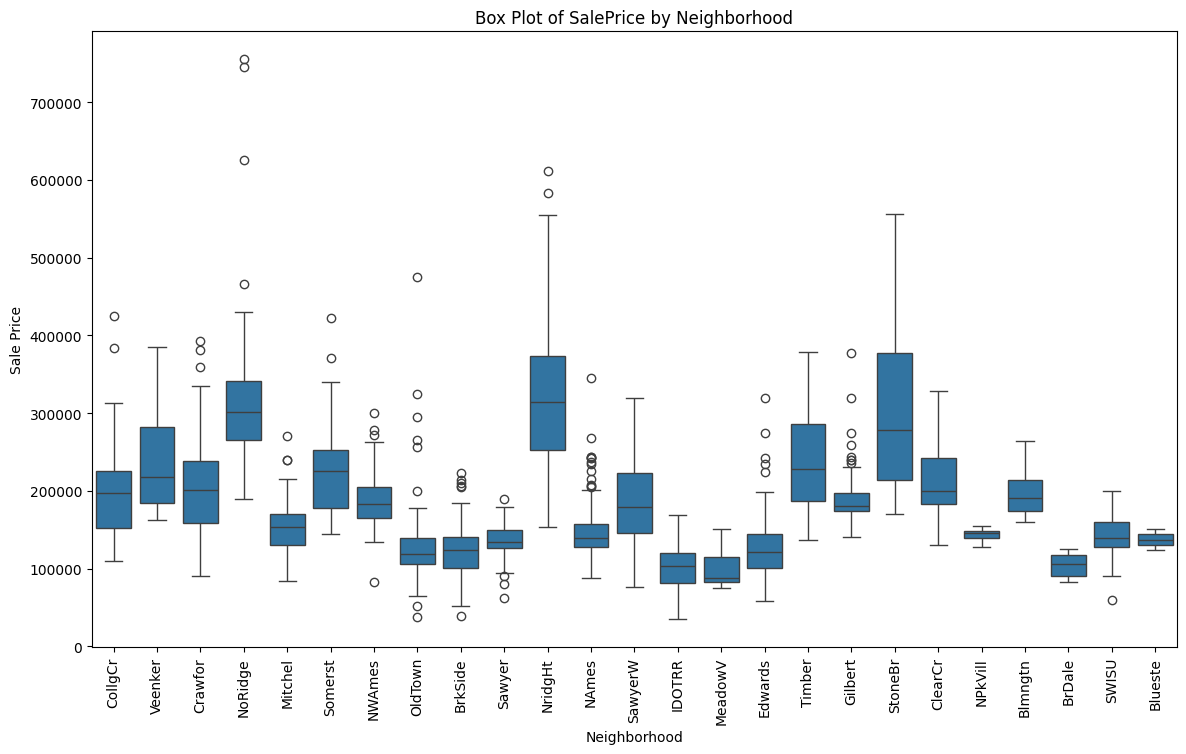

In [20]:
# Box plot of SalePrice by Neighborhood
plt.figure(figsize=(14, 8))
sns.boxplot(x=df_train['Neighborhood'], y=df_train['SalePrice'])
plt.title('Box Plot of SalePrice by Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Sale Price')
plt.xticks(rotation=90)
plt.show()

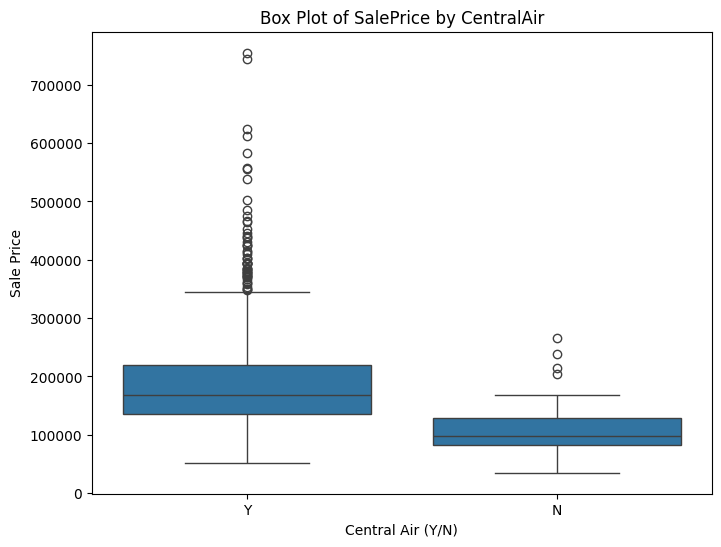

In [21]:
# Box plot of SalePrice by CentralAir
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_train['CentralAir'], y=df_train['SalePrice'])
plt.title('Box Plot of SalePrice by CentralAir')
plt.xlabel('Central Air (Y/N)')
plt.ylabel('Sale Price')
plt.show()

**Data Preprocessing**

In [22]:
# Separate features and target variable
X = df_train.drop('SalePrice', axis=1)
y = df_train['SalePrice']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Log transform the target variable
y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

- Data cleaning

In [23]:
# Handle Multicollinearity
# Select only numeric features
numeric_features = X_train.select_dtypes(include=np.number).columns

# Calculate correlation matrix using only numeric features
correlation_matrix = X_train[numeric_features].corr()

# Drop features with high multicollinearity (> 0.8)
high_corr_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            high_corr_features.add(colname)

# Drop the highly correlated features from both training and testing sets
X_train = X_train.drop(columns=high_corr_features)
X_test = X_test.drop(columns=high_corr_features)  # Ensure to drop the same features from the test set

In [24]:
# Handle Zero Correlation
# Select only numeric features for correlation calculation
numeric_features = X_train.select_dtypes(include=np.number).columns
correlation_with_target = X_train[numeric_features].corrwith(y_train)

zero_corr_features = correlation_with_target[correlation_with_target.abs() < 0.04].index.tolist()  # Adjust the threshold as needed

# Drop the features from both training and testing sets
X_train = X_train.drop(columns=zero_corr_features)
X_test = X_test.drop(columns=zero_corr_features)  # Drop the same features from the test set

In [25]:
# Drop the same features from the unseen dataset df_test
df_test = df_test.drop(columns=high_corr_features.union(zero_corr_features), errors='ignore')  # Use union to combine both sets

- Data preprocessing

In [26]:
# Identify categorical features
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Create preprocessing pipelines
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ]
)

# Apply preprocessing to the data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
df_test_processed = preprocessor.transform(df_test)

**Model Training**

In [27]:
# Initial model for feature selection and cross validation
model = LinearRegression()

# Perform RFECV
selector = RFECV(estimator=model, step=1, cv=5, scoring='neg_mean_squared_error')
selector.fit(X_train_processed, y_train)

# The best features are in selector.support_
#selected_features = X_train_processed.columns[selector.support_]
selected_features = np.array(numerical_features + list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)))[selector.support_]

# Prepare the selected features
X_train_selected = X_train_processed[:, selector.support_]
X_test_selected = X_test_processed[:, selector.support_]
df_test_selected = df_test_processed[:, selector.support_]

# Cross-validated score of the best model
# Access the 'mean_test_score' from cv_results_ instead of grid_scores_
best_rmse = np.sqrt(-selector.cv_results_['mean_test_score']).min()
print(f"Best RMSE: {best_rmse:.4f} with selected features: {selected_features.tolist()}")

Best RMSE: 0.1629 with selected features: ['MSSubClass', 'LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 'GrLivArea', 'BsmtFullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces', 'GarageCars', 'WoodDeckSF', 'ScreenPorch', 'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'Street_Grvl', 'Street_Pave', 'LotShape_IR1', 'LotShape_IR2', 'LotShape_Reg', 'LandContour_Bnk', 'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl', 'Utilities_AllPub', 'Utilities_NoSeWa', 'LotConfig_Corner', 'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3', 'LotConfig_Inside', 'LandSlope_Gtl', 'LandSlope_Mod', 'LandSlope_Sev', 'Neighborhood_Blmngtn', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborh

In [28]:
# Initialize models
models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(),
    'GradientBoosting': GradientBoostingRegressor(),
    'XGBoost': XGBRegressor(),
}

# Cross-validation to evaluate models
model_rmse_scores = {}

for model_name, model in models.items():
    # Use 'neg_mean_squared_error' for scoring
    cv_neg_rmse = cross_val_score(model, X_train_selected, y_train, scoring='neg_mean_squared_error', cv=5)
    model_rmse_scores[model_name] = np.sqrt(-cv_neg_rmse.mean())  # Convert to positive RMSE
    print(f"{model_name} Cross-Validated RMSE: {model_rmse_scores[model_name]:.4f}")

  # Identify the best model
best_model = min(model_rmse_scores, key=model_rmse_scores.get)
best_model_rmse = model_rmse_scores[best_model]
print(f"Best Model: {best_model} with Cross-Validated RMSE: {best_model_rmse:.4f}")

LinearRegression Cross-Validated RMSE: 0.1606
RandomForest Cross-Validated RMSE: 0.1469
GradientBoosting Cross-Validated RMSE: 0.1345
XGBoost Cross-Validated RMSE: 0.1454
Best Model: GradientBoosting with Cross-Validated RMSE: 0.1345


- Hyperparameter Tuning

(Best Gradient Boosting params: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 0.8})

In [29]:
# fine-tuning the best model
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 4, 5],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5],
    'subsample': [0.8]
}

# Initialize GridSearchCV for Gradient Boosting
grid_search = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid_search.fit(X_train_selected, y_train)

# Best parameters and score
best_gb_model = grid_search.best_estimator_
best_gb_rmse = np.sqrt(-grid_search.best_score_)
print(f"Best Gradient Boosting RMSE: {best_gb_rmse:.4f} with params: {grid_search.best_params_}")


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Gradient Boosting RMSE: 0.1321 with params: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 0.8}


**Model Evaluation**

In [30]:
# Predict on the test set (keep predictions in log scale)
y_pred_log = best_gb_model.predict(X_test_selected)

# Step 2: Calculate RMSE on the log scale
# You might already have y_test in log scale; if not, ensure to log-transform it
# Example: y_test_log = np.log(y_test_original) if y_test_original is available
rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_log))
mae_log = mean_absolute_error(y_test, y_pred_log)
r2_log = r2_score(y_test, y_pred_log)

print(f"RMSE on log scale: {rmse_log:.4f}")
print(f"R² Score on log scale: {r2_log:.4f}")
print(f"Mean Absolute Error (MAE): {mae_log:.4f}")

RMSE on log scale: 0.1343
R² Score on log scale: 0.9033
Mean Absolute Error (MAE): 0.0914


In [31]:
# model evaluation on the original scale
y_pred_log = best_gb_model.predict(X_test_selected)

# Inverse log transform predictions
y_pred = np.exp(y_pred_log)
y_test_original = np.exp(y_test)  # If y_test was log-transformed too

# Step 3: Calculate RMSE and other metrics on the original scale
rmse_original = np.sqrt(mean_squared_error(y_test_original, y_pred))
mae = mean_absolute_error(y_test_original, y_pred)
r2 = r2_score(y_test_original, y_pred)

print(f"RMSE on original scale: {rmse_original:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

RMSE on original scale: 25600.3938
Mean Absolute Error (MAE): 15766.0110
R² Score: 0.9146


**Submission File**

In [34]:
# Load the sample submission file
sample_submission = pd.read_csv('/content/sample_submission.csv')


# Make predictions on the unseen data (test set)
y_pred_log = best_gb_model.predict(df_test_selected)
y_pred_original_scale = np.exp(y_pred_log)

# Prepare the submission DataFrame
submission_df = pd.DataFrame({
    'Id': sample_submission['Id'],  # Keep the Ids from the sample submission
    'SalePrice': y_pred_original_scale  # Use the original scale predictions
})

# Save the submission DataFrame to a CSV file
submission_file = '/content/submission_file.csv'
submission_df.to_csv(submission_file, index=False)

print(f"Submission file saved to {submission_file}")

Submission file saved to /content/submission_file.csv


In [35]:
submission_file = pd.read_csv('/content/submission_file.csv')
submission_file.head(10)

,Id,SalePrice
0,1461,123622.132496
1,1462,155253.147693
2,1463,181603.176868
3,1464,191093.537589
4,1465,210788.168100
5,1466,181232.379868
6,1467,172516.343592
7,1468,171460.401290
8,1469,191759.601151
9,1470,127075.041313
